In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

#code wrote by Alan supported by Chatgpt

In [8]:
def watershed_optic_disc_cup_detection(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply median blur to remove noise
    blurred_img = cv2.medianBlur(gray, 5)
    
    # Binary thresholding to separate the optic disc and cup from the rest
    ret, thresh = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Noise removal using morphological opening
    kernel = np.ones((2, 2), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area (Dilation increases object boundary to background)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
    
    # Finding unknown region which is the boundary between the optic disc and cup
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1
    
    # Mark the region of unknown with zero
    markers[unknown == 255] = 0
    
    # Apply the Watershed algorithm
    markers = cv2.watershed(img, markers)
    
    # Mark the boundaries
    img[markers == -1] = [255, 0, 0]
    
    return img

image_path = 'Glaucoma_Balanced_Dataset/JustRAIGS/TRAIN000000.jpg'

processed_image = watershed_optic_disc_cup_detection(image_path)

#cv2.imwrite('processed_image.jpg', processed_image)
#cv2.imshow('Processed Image', processed_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

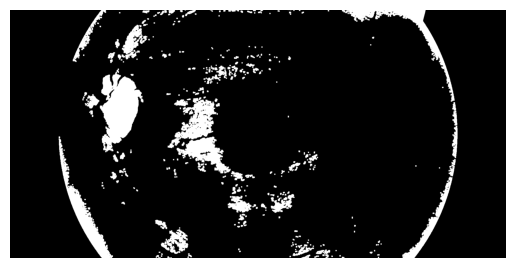

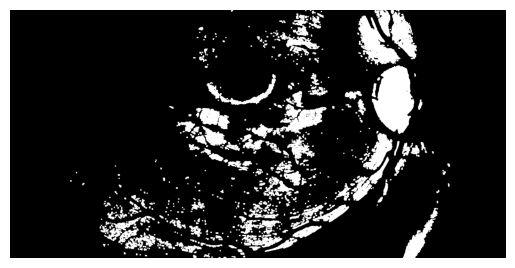

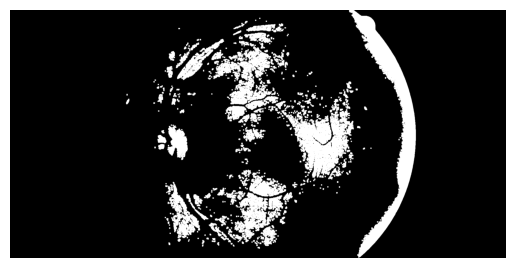

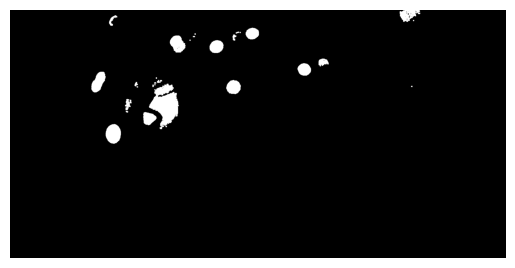

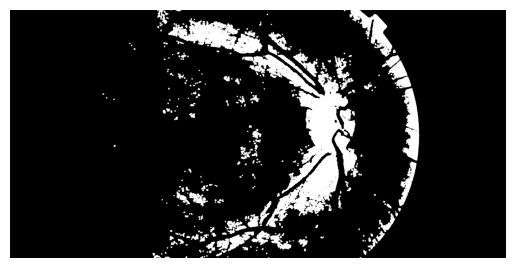

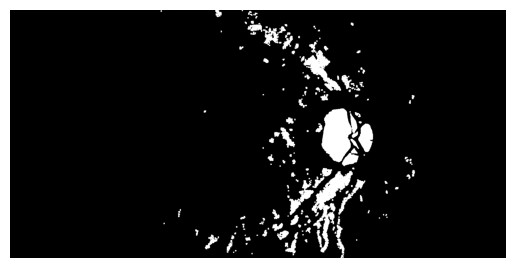

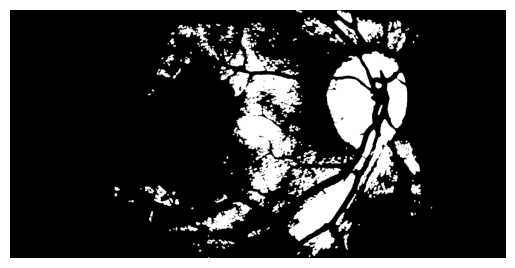

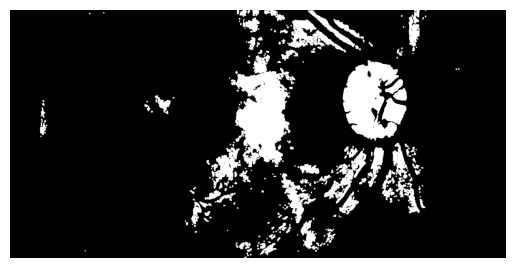

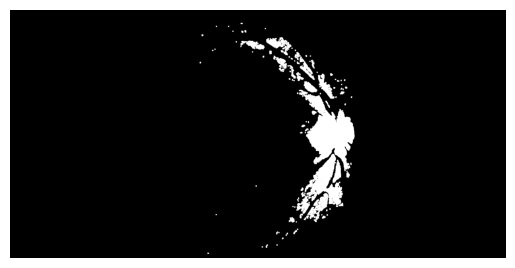

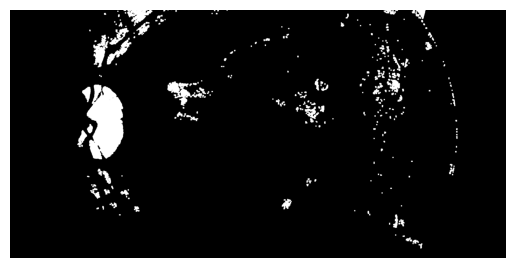

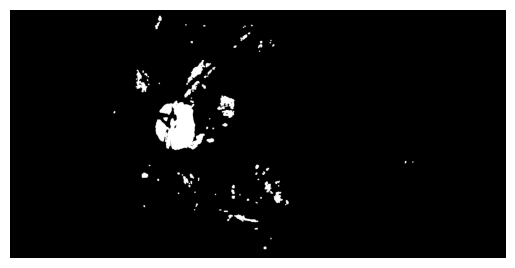

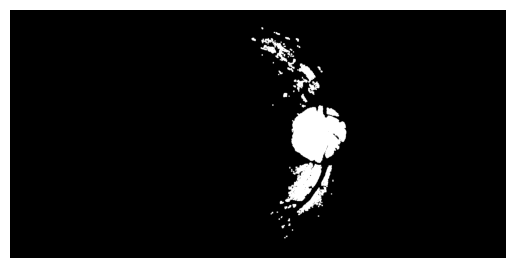

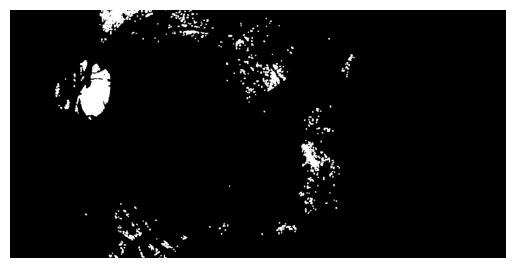

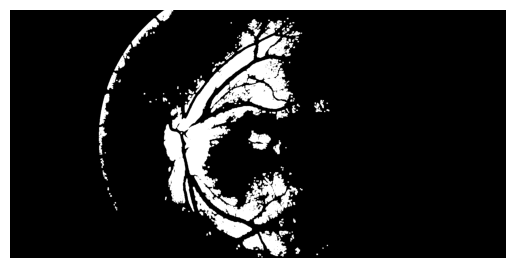

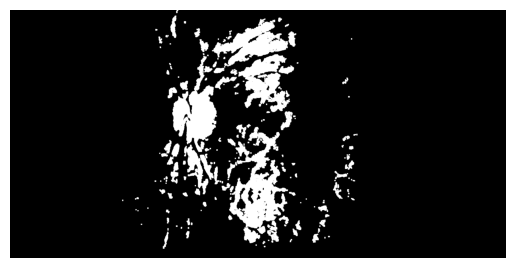

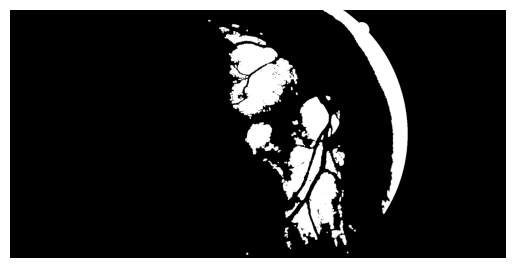

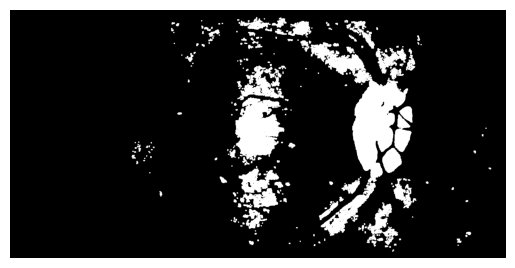

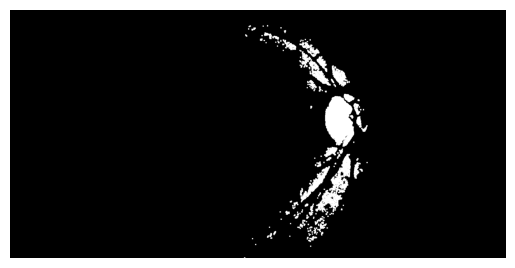

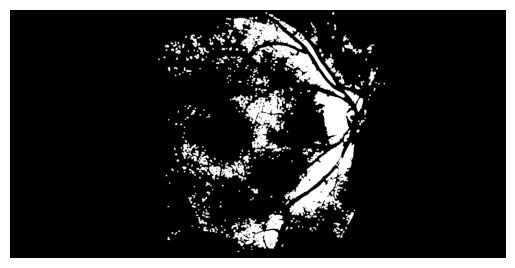

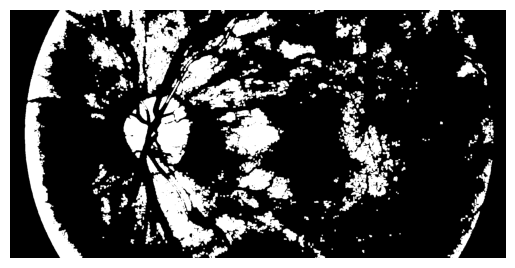

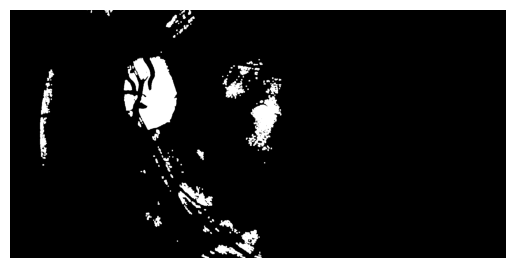

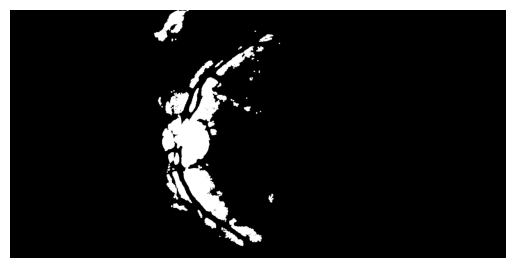

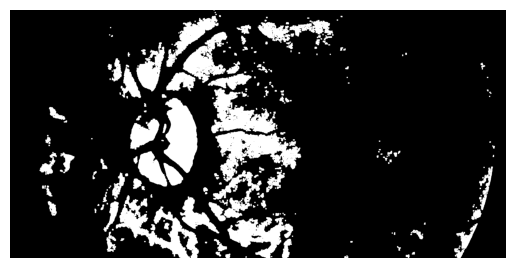

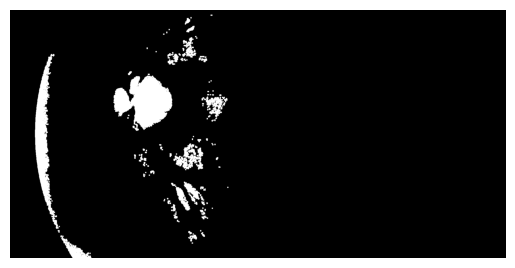

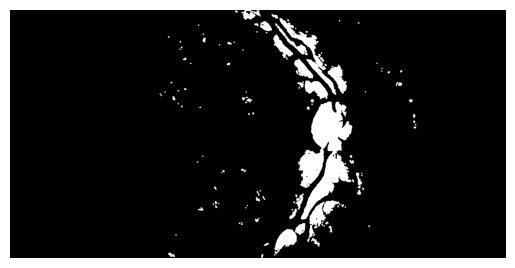

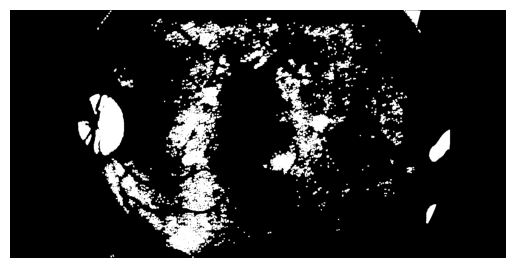

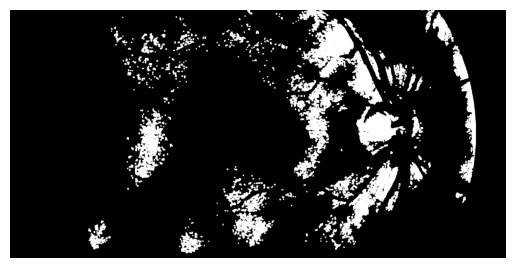

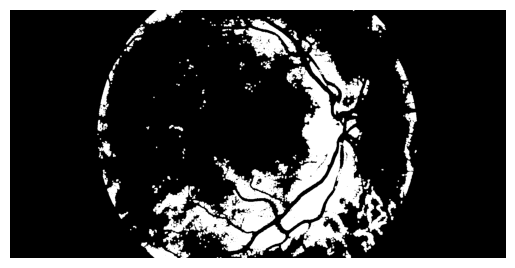

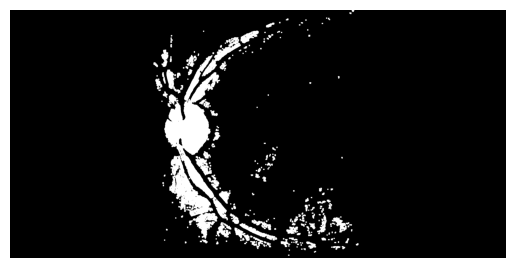

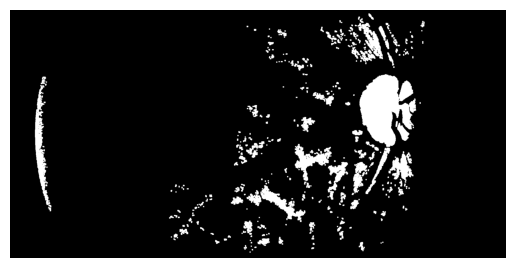

In [13]:
def detect_optic_disc_and_cup(image_path):
    # Load the image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE to enhance contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(gray)

    # Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(clahe_img, (7, 7), 0)

    # Binary thresholding to get the brightest regions that will include the optic disc
    _, disc_thresh = cv2.threshold(blurred, 70, 255, cv2.THRESH_BINARY)

    # Morphological closing to fill gaps in the optic disc
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(disc_thresh, cv2.MORPH_CLOSE, kernel)

    # Find contours and select the largest one, assuming it's the optic disc
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    optic_disc_contour = max(contours, key=cv2.contourArea)
    disc_mask = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(disc_mask, [optic_disc_contour], -1, (255), thickness=cv2.FILLED)

    # Create a mask for the optic cup by applying threshold to the optic disc area
    optic_disc_only = cv2.bitwise_and(clahe_img, clahe_img, mask=disc_mask)
    _, cup_thresh = cv2.threshold(optic_disc_only, 150, 255, cv2.THRESH_BINARY)  # Increase threshold if needed

    # Morphological opening to remove noise in the optic cup mask
    opening = cv2.morphologyEx(cup_thresh, cv2.MORPH_OPEN, kernel)

    return opening


#Input Images from File to train the model 
# Specify the folder containing the images and CSV file
folder_path = 'Glaucoma_Balanced_Dataset/Preprocessed_images_input_to_bound'

# Load preprocessed images
images = []    #images should not be a list, it needs to be a 4D numpy array
for i in range(30):  # Assuming 30 images starting from 000000
    image_filename = f'enhanced_TRAIN{i:06d}.jpg'  # Zero-padded 6-digit number
    image_path = os.path.join(folder_path, image_filename)
    #image = cv2.imread(image_path)
    processed_mask = detect_optic_disc_and_cup(image_path)
    images.append(processed_mask)



    

    plt.imshow(processed_mask, cmap='gray')
    plt.axis('off')
    plt.show()